# __Neural Networks__
## Exam Project: Adversarial Training for Free!

**Students**:
- **Name**: *Gianmarco Scarano* | Matricola Code: *2047315*<br>
- **Name**: *Giancarlo Tedesco* | Matricola Code: *2057231*

### Google Colab compatibility
Run this next cell only if you're using Google Colab!

In [ ]:
# Library needed for this notebook
!pip install -U tqdm --quiet

# Imports

In [1]:
# We set the global variable for Google Colab, so we can assign possible paths, etc. accordingly
try:
  import google.colab
  RunningInCOLAB = True
except:
  RunningInCOLAB = False

In [1]:
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

print('Dependecies loaded')
print("===================================================")

Dependecies loaded


## Check if we have CUDA support

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print('Cuda available: {}'.format(torch.cuda.is_available()))
    print("GPU: " + torch.cuda.get_device_name(torch.cuda.current_device()))
    print("Total memory: {:.1f} GB".format((float(torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)))))
    print("===================================================")
else:
    device = torch.device("cpu")
    print('Cuda not available, so using CPU. Please consider switching to a GPU runtime before running the notebook!')

Cuda available: True
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Total memory: 6.0 GB


# Fashion MNIST Dataset

In [3]:
# Data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
# Download the train dataset
train_dataset = datasets.FashionMNIST(root ='./', train=True, download=True, transform=transform)

# Download the test dataset
test_dataset = datasets.FashionMNIST(root ='./', train=False, download=True, transform=transform)

# Create train and test data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model definition: DummyNet

In [5]:
class DummyNet(nn.Module):
    def __init__(self, num_classes=10):
        super(DummyNet, self).__init__()

        # First convolution
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, device=device)
        self.bn1 = nn.BatchNorm2d(32, device=device)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolution
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, device=device)
        self.bn2 = nn.BatchNorm2d(64, device=device)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolution
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1, device=device)
        self.bn3 = nn.BatchNorm2d(32, device=device)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(288, 150, device=device) # 288 is the output shape of the Flatten() function applied after the 3rd convolutional block.
        self.fc2 = nn.Linear(150, 50, device=device)
        self.fc3 = nn.Linear(50, num_classes, device=device)

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x)))) # First convolution
        x = self.pool2(self.relu(self.bn2(self.conv2(x)))) # Second convolution
        x = self.pool3(self.relu(self.bn3(self.conv3(x)))) # Third convolution

        x = self.flatten(x) # Flatten of the output of the 3rd convolutional block

        x = self.relu(self.fc1(x))  # FC1
        x = self.relu(self.fc2(x))  # FC2

        x = self.fc3(x)             # Output layer
        return self.softmax(x)      # Final activation function (SoftMax)

# Training phase

## Training parameters

In [55]:
# Let's define some variables for the training phase
lr = 1e-3
momentum = 0.9
epochs = 100

# Our model
model = DummyNet(num_classes=10)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

## FreeAdversarial parameters

In [56]:
m = 2 # Usually it's a value m ≤ 10
epochs = int(epochs / m)
epsilon = 0.5
delta = torch.zeros([32, 1, 28, 28], device=device)

## Actual training phase (Normal + FreeAdv)

TODO:
- Scalability for input sizes (W, H, D)
- In the training loop, the accuracy is calculated for each iteration.
  This is not correct, as the accuracy should be calculated for each epoch, after all training images are processed.
- The validation accuracy is not being printed after each epoch.
- The division of the images by std is not correct, before the forward pass, it should be images = (images - mean) / std

In [57]:
correct = 0
total = 0
noise_batch = None

# Train the model
for epoch in range(epochs): # 3: for epoch = 1 . . . Nep/m do

    mean = torch.Tensor(np.array([0.1307])[:, np.newaxis, np.newaxis])
    mean = mean.expand(1, 28, 28).cuda()
    std = torch.Tensor(np.array([0.3081])[:, np.newaxis, np.newaxis])
    std = std.expand(1, 28, 28).cuda()

    model.train()
    
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=F"Epoch n.{epoch+1} (Train)")): # 4: for minibatch B ⊂ X do

        # We need to move to the GPU otherwise PyTorch will give issues when adding noise_batch to images
        images = images.to(device=device)
        labels = labels.to(device=device)

        for j in range(m): # 5: for i = 1 . . . m do

            # We want our model to not be trained on simple images but on images with noise δ (delta)
            noise_batch = delta[0:images.size(0)].to(device=device).requires_grad_(True)
            images += noise_batch
            images.clamp_(0, 1.0)
            images.sub_(mean).div_(std)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward(retain_graph=True) # 7: gθ ← E(x,y)∈B[∇θ l(x + δ, y, θ)] + 9: θ ← θ − τgθ ----> Plus we go popolate the noise_batch.grad value

            gadv = noise_batch.grad # 8: gadv ← ∇x l(x + δ, y, θ)] ---> We already computed this, we are just storing it in a variable

            # Update the noise for the next iteration
            delta[0:images.size(0)] = delta[0:images.size(0)] + (epsilon * torch.sign(gadv)) # 11: δ ← δ + eps · sign(gadv)
            
            delta[0:images.size(0)] = torch.clamp_(delta[0:images.size(0)], - epsilon, epsilon) # 12: δ ← clip(δ, -eps, eps)

            optimizer.step()
            
            # For testing
            if epoch == 0 and j == 0:
                imagesNorm = images
                imagesPert = images + (epsilon * torch.sign(gadv))
                
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / len(labels)

    # Test the model
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0

        mean = torch.Tensor(np.array([0.1307])[:, np.newaxis, np.newaxis])
        mean = mean.expand(1, 28, 28).cuda()
        std = torch.Tensor(np.array([0.3081])[:, np.newaxis, np.newaxis])
        std = std.expand(1, 28, 28).cuda()

        for images, labels in tqdm(test_loader, desc=F"Epoch n.{epoch+1} (Validation)"):
            
            images = images.to(device=device)
            labels = labels.to(device=device)
            
            # compute output
            images.sub_(mean).div_(std)

            outputs = model(images)

            lossVal = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print the loss and accuracy every 10 epochs
    print(f'Epoch {epoch+1:03}:')     
    print(f'\t- Training accuracy   : {accuracy:.4f}')
    print(f'\t- Training loss       : {loss.item():.4f}')
    print(f'\t- Validation accuracy : {correct / total:.4f}')
    print(f'\t- Validation loss : {lossVal.item():.4f}')
    print("=========================================")

Epoch n.1 (Validation): 100%|██████████| 313/313 [00:03<00:00, 101.46it/s]


Epoch 001:
	- Training accuracy   : 0.5312
	- Training loss       : 1.8885
	- Validation accuracy : 0.3742
	- Validation loss : 2.0210


Epoch n.2 (Validation): 100%|██████████| 313/313 [00:03<00:00, 100.54it/s]


Epoch 002:
	- Training accuracy   : 0.4375
	- Training loss       : 1.9825
	- Validation accuracy : 0.4219
	- Validation loss : 1.9430


Epoch n.3 (Validation): 100%|██████████| 313/313 [00:03<00:00, 100.93it/s]


Epoch 003:
	- Training accuracy   : 0.3750
	- Training loss       : 2.0397
	- Validation accuracy : 0.3221
	- Validation loss : 1.9463


Epoch n.4 (Train):  92%|█████████▏| 1728/1875 [00:34<00:02, 50.03it/s]


KeyboardInterrupt: 

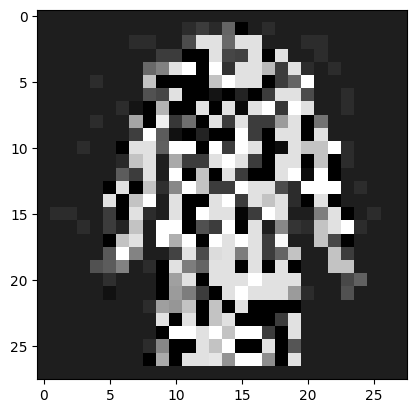

In [65]:
import matplotlib.pyplot as plt

images1 = images + (epsilon * torch.sign(gadv))

pp = np.array(images1[21].detach().cpu(), dtype='float')

plt.imshow(pp.reshape(28,28,1), cmap='gray')